<a href="https://colab.research.google.com/github/mat7ie/The-Game/blob/main/Speech_command.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
!pip install tensorflow librosa matplotlib tf2onnx

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 455.8/455.8 kB 24.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 16.0/16.0 MB 31.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 162.1/162.1 kB 13.2 MB/s eta 0:00:00
  Attempting uninstall: protobuf
    Found existing installation: protobuf 5.29.4
    Uninstalling protobuf-5.29.4:
      Successfully uninstalled protobuf-5.29.4
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
grpcio-status 1.71.0 requires protobuf<6.0dev,>=5.26.1, but you have protobuf 3.20.3 which is incompatible.
ydf 0.11.0 requires protobuf<6.0.0,>=5.29.1, but you have protobuf 3.20.3 which is incompatible.
tensorflow-metadata 1.17.0 requires protobuf<6.0.0,>=4.25.2; python_version >= "3.11", but you have protobuf 3.20.3 which is incompatible.


In [ ]:
import tensorflow as tf
import numpy as np
import librosa
import matplotlib.pyplot as plt
import os
from sklearn.model_selection import train_test_split
import tf2onnx
from tensorflow.keras.layers import Input
from tensorflow.keras.regularizers import l2

In [ ]:
data_dir = "/content/drive/MyDrive/dataset"
labels = os.listdir(data_dir)
print("Labels:", labels)

total_files = 0
for label in labels:
    label_dir = os.path.join(data_dir, label)
    if os.path.isdir(label_dir):
        num_files = len(os.listdir(label_dir))
        total_files += num_files
        print(f"{label}: {num_files} files")

print("\nTổng số file trong dataset:", total_files)

Labels: ['stop', 'right', 'down', 'go', 'left', 'up']
stop: 495 files
right: 438 files
down: 492 files
go: 431 files
left: 491 files
up: 460 files

Tổng số file trong dataset: 2807


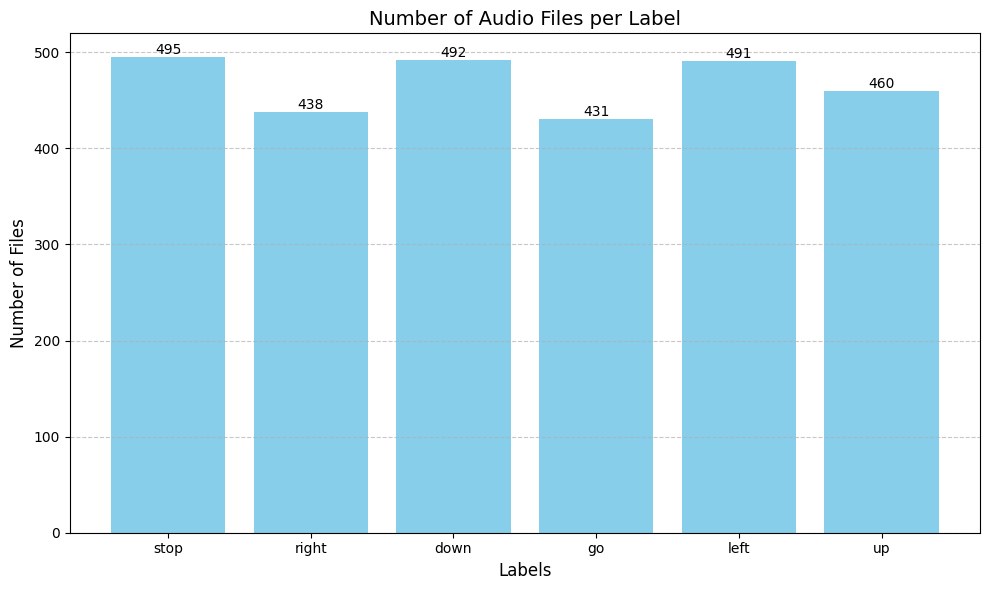

In [ ]:
file_counts = []
for label in labels:
    label_dir = os.path.join(data_dir, label)
    if os.path.isdir(label_dir):
        num_files = len(os.listdir(label_dir))
        file_counts.append(num_files)
    else:
        file_counts.append(0)

plt.figure(figsize=(10, 6))
bars = plt.bar(labels, file_counts, color='skyblue')

for bar in bars:
    height = bar.get_height()
    plt.text(bar.get_x() + bar.get_width()/2., height,
             '%d' % int(height),
             ha='center', va='bottom')

plt.xlabel('Labels', fontsize=12)
plt.ylabel('Number of Files', fontsize=12)
plt.title('Number of Audio Files per Label', fontsize=14)

plt.grid(axis='y', linestyle='--', alpha=0.7)

plt.tight_layout()
plt.show()

In [ ]:
def augment_audio(audio):
    # Time stretching
    if np.random.rand() < 0.3:
        rate = np.random.uniform(0.9, 1.1)
        audio = librosa.effects.time_stretch(audio, rate=rate)

    # Add random noise
    if np.random.rand() < 0.3:
        noise = np.random.normal(0, 0.005, audio.shape)
        audio = audio + noise

    # Pitch shifting
    if np.random.rand() < 0.3:
        n_steps = np.random.randint(-3, 3)
        audio = librosa.effects.pitch_shift(audio, sr=16000, n_steps=n_steps)

    return audio

In [ ]:
def load_wav(file_path, max_length=16000, augment=False):
    audio, sr = librosa.load(file_path, sr=16000)
    if len(audio) > max_length:
        audio = audio[:max_length]
    else:
        audio = np.pad(audio, (0, max(0, max_length - len(audio))), "constant")

    if augment:
        audio = augment_audio(audio)

    return audio

def audio_to_mfcc(audio, n_mfcc=40):
    # Compute MFCCs (shape: [n_mfcc, time_steps])
    mfcc = librosa.feature.mfcc(
        y=audio,
        sr=16000,
        n_mfcc=n_mfcc,
        n_fft=512,
        hop_length=256
    )
    # Transpose to [time_steps, n_mfcc] and add channel dimension for CNN
    return mfcc.T[..., np.newaxis]  # Shape: (time_steps, n_mfcc, 1)

In [ ]:
def create_dataset(data_dir, labels, max_length=16000):
    X, y = [], []
    for label_idx, label in enumerate(labels):
        label_dir = os.path.join(data_dir, label)
        for file in os.listdir(label_dir):
            file_path = os.path.join(label_dir, file)
            audio = load_wav(file_path, max_length)
            mfcc = audio_to_mfcc(audio)  # Use MFCC
            X.append(mfcc)
            y.append(label_idx)
    return np.array(X), np.array(y)

X, y = create_dataset(data_dir, labels)

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2)

print("MFCC shape:", X[0].shape)

MFCC shape: (63, 40, 1)


In [ ]:
# Define model using Functional API
# input_layer = Input(shape=(63, 40, 1), name="input")  # Name the input layer
# x = tf.keras.layers.Conv2D(32, (3, 3), activation='relu')(input_layer)
# x = tf.keras.layers.MaxPooling2D((2, 2))(x)
# x = tf.keras.layers.Conv2D(64, (3, 3), activation='relu')(x)
# x = tf.keras.layers.MaxPooling2D((2, 2))(x)
# x = tf.keras.layers.Flatten()(x)
# x = tf.keras.layers.Dense(64, activation='relu')(x)

# Define model using Functional API
input_layer = Input(shape=(63, 40, 1), name="input")  # Name the input layer
x = tf.keras.layers.Conv2D(32, (3, 3), activation='relu', kernel_regularizer=l2(0.001))(input_layer)
x = tf.keras.layers.BatchNormalization()(x)
x = tf.keras.layers.MaxPooling2D((2, 2))(x)
x = tf.keras.layers.Dropout(0.25)(x)

x = tf.keras.layers.Conv2D(64, (3, 3), activation='relu', kernel_regularizer=l2(0.001))(x)
x = tf.keras.layers.BatchNormalization()(x)
x = tf.keras.layers.MaxPooling2D((2, 2))(x)
x = tf.keras.layers.Dropout(0.25)(x)

# Flatten and fully connected layers
x = tf.keras.layers.Flatten()(x)
x = tf.keras.layers.Dense(64, activation='relu')(x)
x = tf.keras.layers.BatchNormalization()(x)
x = tf.keras.layers.Dropout(0.5)(x)

output_layer = tf.keras.layers.Dense(len(labels), activation='softmax', name="output")(x)  # Name the output

model = tf.keras.Model(inputs = input_layer, outputs = output_layer)

model.compile(
    optimizer='adam',
    loss='sparse_categorical_crossentropy',
    metrics=['accuracy']
)

print(model.summary())

Model: "functional"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input (InputLayer)              │ (None, 63, 40, 1)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d (Conv2D)                 │ (None, 61, 38, 32)     │           320 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization             │ (None, 61, 38, 32)     │           128 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d (MaxPooling2D)    │ (None, 30, 19, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 30, 19, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_1 (Conv2D)               │ (None, 28, 17, 64)     │        18,496 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_1           │ (None, 28, 17, 64)     │           256 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_1 (MaxPooling2D)  │ (None, 14, 8, 64)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_1 (Dropout)             │ (None, 14, 8, 64)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten (Flatten)               │ (None, 7168)           │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 64)             │       458,816 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_2           │ (None, 64)             │           256 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_2 (Dropout)             │ (None, 64)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ output (Dense)                  │ (None, 6)              │           390 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 478,662 (1.83 MB)

 Trainable params: 478,342 (1.82 MB)

 Non-trainable params: 320 (1.25 KB)

None


In [ ]:
lr_scheduler = tf.keras.callbacks.ReduceLROnPlateau(
    monitor='val_loss',
    factor=0.5,
    patience=2,
    min_lr=1e-6
)

early_stopping = tf.keras.callbacks.EarlyStopping(
    monitor='val_loss',
    patience=5,
    restore_best_weights=True
)

history = model.fit(
    X_train, y_train,
    validation_data=(X_test, y_test),
    epochs=30,  # Use more epochs with early stopping
    batch_size=32,
    callbacks=[lr_scheduler, early_stopping]
)

Epoch 1/30
71/71 ━━━━━━━━━━━━━━━━━━━━ 24s 236ms/step - accuracy: 0.2674 - loss: 2.3917 - val_accuracy: 0.4466 - val_loss: 1.8461 - learning_rate: 0.0010
Epoch 2/30
71/71 ━━━━━━━━━━━━━━━━━━━━ 16s 169ms/step - accuracy: 0.5206 - loss: 1.4097 - val_accuracy: 0.6228 - val_loss: 1.1586 - learning_rate: 0.0010
Epoch 3/30
71/71 ━━━━━━━━━━━━━━━━━━━━ 21s 184ms/step - accuracy: 0.6273 - loss: 1.0520 - val_accuracy: 0.6548 - val_loss: 1.0099 - learning_rate: 0.0010
Epoch 4/30
71/71 ━━━━━━━━━━━━━━━━━━━━ 23s 216ms/step - accuracy: 0.7089 - loss: 0.8968 - val_accuracy: 0.7242 - val_loss: 0.8599 - learning_rate: 0.0010
Epoch 5/30
71/71 ━━━━━━━━━━━━━━━━━━━━ 24s 261ms/step - accuracy: 0.7469 - loss: 0.7677 - val_accuracy: 0.7367 - val_loss: 0.8271 - learning_rate: 0.0010
Epoch 6/30
71/71 ━━━━━━━━━━━━━━━━━━━━ 25s 328ms/step - accuracy: 0.7925 - loss: 0.6519 - val_accuracy: 0.7758 - val_loss: 0.7030 - learning_rate: 0.0010
Epoch 7/30
71/71 ━━━━━━━━━━━━━━━━━━━━ 30s 168ms/step - accuracy: 0.8056 - loss: 0.

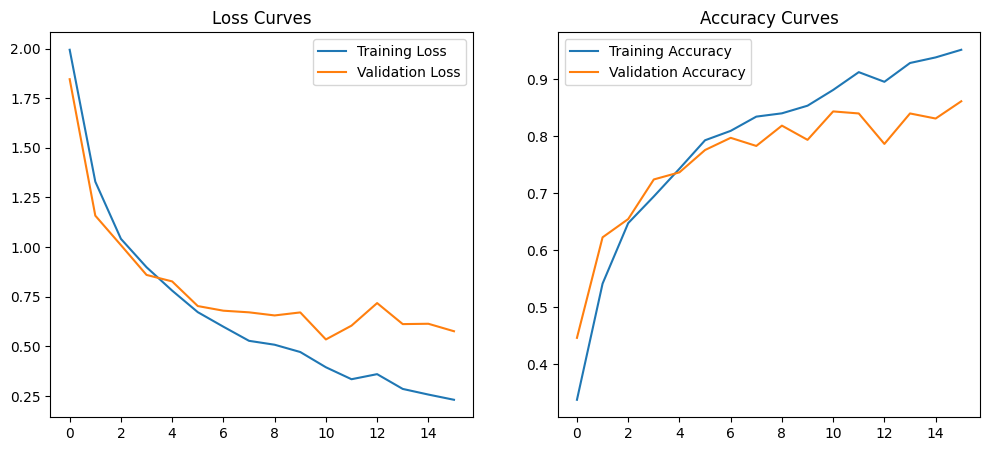

In [ ]:
# Plot results
plt.figure(figsize=(12, 5))
plt.subplot(1, 2, 1)
plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.title('Loss Curves')
plt.legend()

plt.subplot(1, 2, 2)
plt.plot(history.history['accuracy'], label='Training Accuracy')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
plt.title('Accuracy Curves')
plt.legend()

plt.show()

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix, accuracy_score, classification_report
import seaborn as sns

# Dự đoán nhãn từ X_test
y_pred = model.predict(X_test)
y_pred_classes = np.argmax(y_pred, axis=1)  # Chuyển từ xác suất sang lớp

18/18 ━━━━━━━━━━━━━━━━━━━━ 1s 36ms/step


In [ ]:
accuracy = accuracy_score(y_test, y_pred_classes)
print(f"Accuracy: {accuracy * 100:.2f}%")

Accuracy: 84.34%


In [ ]:
print(classification_report(y_test, y_pred_classes, target_names=labels))

              precision    recall  f1-score   support

        stop       0.99      0.82      0.89        92
       right       0.87      0.94      0.90        95
        down       0.81      0.85      0.83        91
          go       0.83      0.87      0.85        92
        left       0.81      0.76      0.79       101
          up       0.78      0.84      0.80        91

    accuracy                           0.84       562
   macro avg       0.85      0.84      0.84       562
weighted avg       0.85      0.84      0.84       562



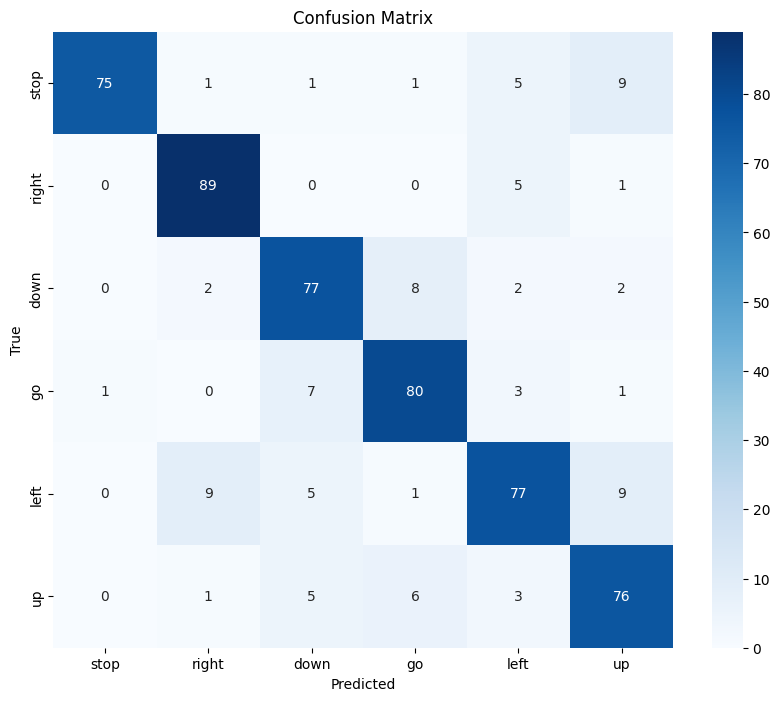

In [ ]:
def plot_confusion_matrix(y_true, y_pred, classes):
    cm = confusion_matrix(y_true, y_pred)
    plt.figure(figsize=(10, 8))
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=classes, yticklabels=classes)
    plt.xlabel('Predicted')
    plt.ylabel('True')
    plt.title('Confusion Matrix')
    plt.show()

# Gọi hàm với nhãn lớp cụ thể (VD: ['cat', 'dog', ...])
plot_confusion_matrix(y_test, y_pred_classes, labels)

In [ ]:
error_indices = np.where(y_pred_classes != y_test)[0]
print(f"Số mẫu bị phân loại sai: {len(error_indices)}/{len(y_test)}")

# Xem ví dụ sai cụ thể (VD: mẫu đầu tiên bị sai)
sample_idx = error_indices[0]
print("True label:", labels[y_test[sample_idx]])
print("Predicted label:", labels[y_pred_classes[sample_idx]])

Số mẫu bị phân loại sai: 88/562
True label: stop
Predicted label: left


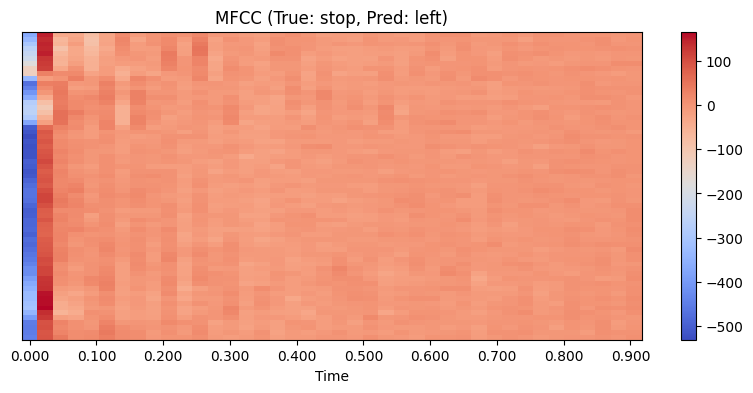

In [ ]:
plt.figure(figsize=(10, 4))
librosa.display.specshow(X_test[sample_idx][:, :, 0], x_axis='time')
plt.title(f"MFCC (True: {labels[y_test[sample_idx]]}, Pred: {labels[y_pred_classes[sample_idx]]})")
plt.colorbar()
plt.show()

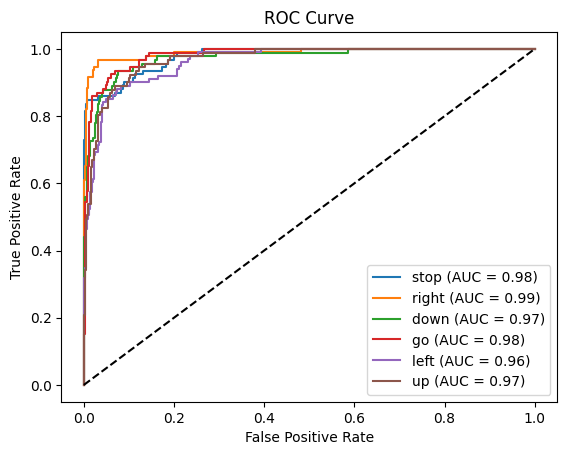

In [ ]:
from sklearn.metrics import roc_curve, auc
from sklearn.preprocessing import label_binarize

# Chuyển nhãn sang dạng one-hot
y_test_bin = label_binarize(y_test, classes=np.arange(len(labels)))
y_pred_bin = y_pred  # Đã là xác suất từ model.predict()

# Tính ROC cho từng lớp
fpr, tpr, roc_auc = {}, {}, {}
for i in range(len(labels)):
    fpr[i], tpr[i], _ = roc_curve(y_test_bin[:, i], y_pred_bin[:, i])
    roc_auc[i] = auc(fpr[i], tpr[i])

# Vẽ ROC
plt.figure()
for i in range(len(labels)):
    plt.plot(fpr[i], tpr[i], label=f'{labels[i]} (AUC = {roc_auc[i]:.2f})')
plt.plot([0, 1], [0, 1], 'k--')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve')
plt.legend()
plt.show()

In [ ]:
import random
from IPython.display import Audio, display

def test():
    # Select a random label and file
    random_label = random.choice(labels)
    label_dir = os.path.join(data_dir, random_label)
    random_file = random.choice(os.listdir(label_dir))
    file_path = os.path.join(label_dir, random_file)

    # Play the audio
    display(Audio(file_path, autoplay=False))  # Let the user click play

    # Predict
    audio = load_wav(file_path)
    mfcc = audio_to_mfcc(audio)
    pred = model.predict(mfcc[np.newaxis, ...])
    predicted_label = labels[np.argmax(pred)]

    print(f"True Label: {random_label}")
    print(f"Predicted Label: {predicted_label}")

# Run the test
test()

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 57ms/step
True Label: right
Predicted Label: right


In [ ]:
# Save the model in TensorFlow format first
model.save("/content/drive/MyDrive/speech_model.h5")

In [ ]:
# Convert to ONNX
spec = (tf.TensorSpec((None, 63, 40, 1), tf.float32, name="input"),)
model_proto, _ = tf2onnx.convert.from_keras(model, input_signature=spec, output_path="/content/drive/MyDrive/speech_model_2.onnx")

ERROR:tf2onnx.tfonnx:rewriter <function rewrite_constant_fold at 0x7dbf28994cc0>: exception `np.cast` was removed in the NumPy 2.0 release. Use `np.asarray(arr, dtype=dtype)` instead.
